# Setup

In [2]:
import sys
sys.path.append("../../ELDR-reproduction/Code")
sys.path.append("../../ELDR-reproduction/scvis/lib/scvis")

# ELDR Housing

In [4]:
# Chosen using results from Housing-K
epsilon = 1.5
k = 5

input_dim = 13
num_clusters = 6

model_file = "../../ELDR-reproduction/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

feature_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

import csv
import json
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_change
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
# Load Data & Configuration

x = pd.read_csv("../../Data/Housing/X.tsv", sep="\t").values

y = pd.read_csv("../../Data/Housing/y.tsv", sep="\t").values

with open("../../ELDR-reproduction/Housing/vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [6]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


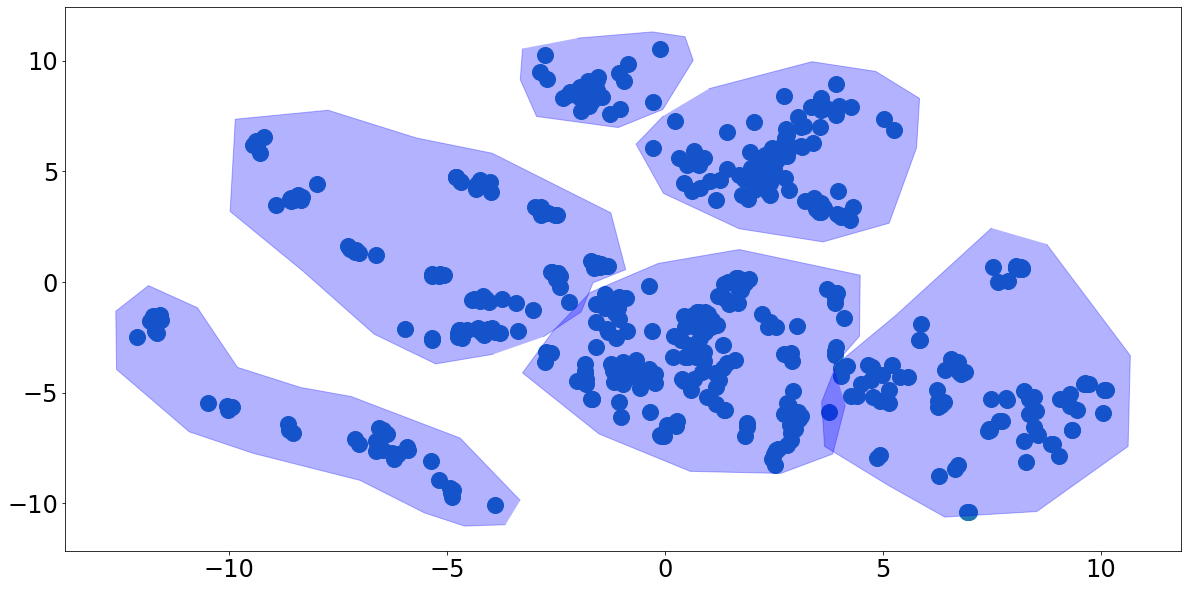

In [ ]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)


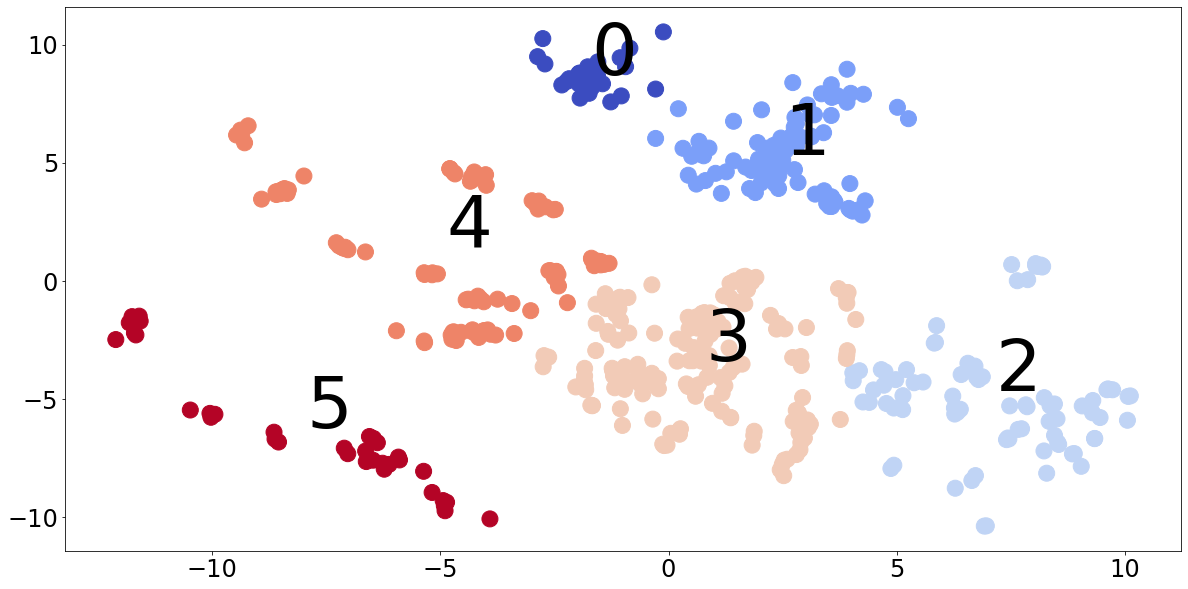

In [7]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "housing-rep.png")
 

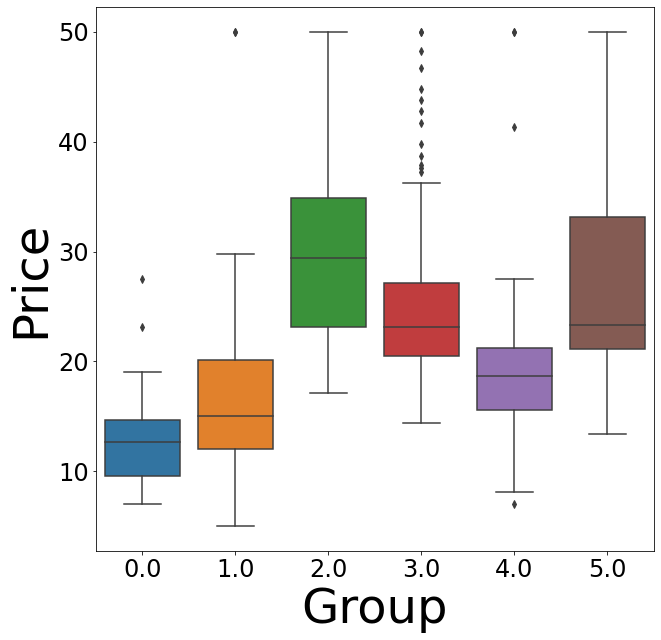

In [ ]:
# See what signal is enocded in the clusters

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(ax = ax, x = labels, y = np.squeeze(y))
ax.set(xlabel = "Group", ylabel = "Price")
ax.get_figure().savefig("housing-labels.png")

INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


/content/ELDR/Code/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


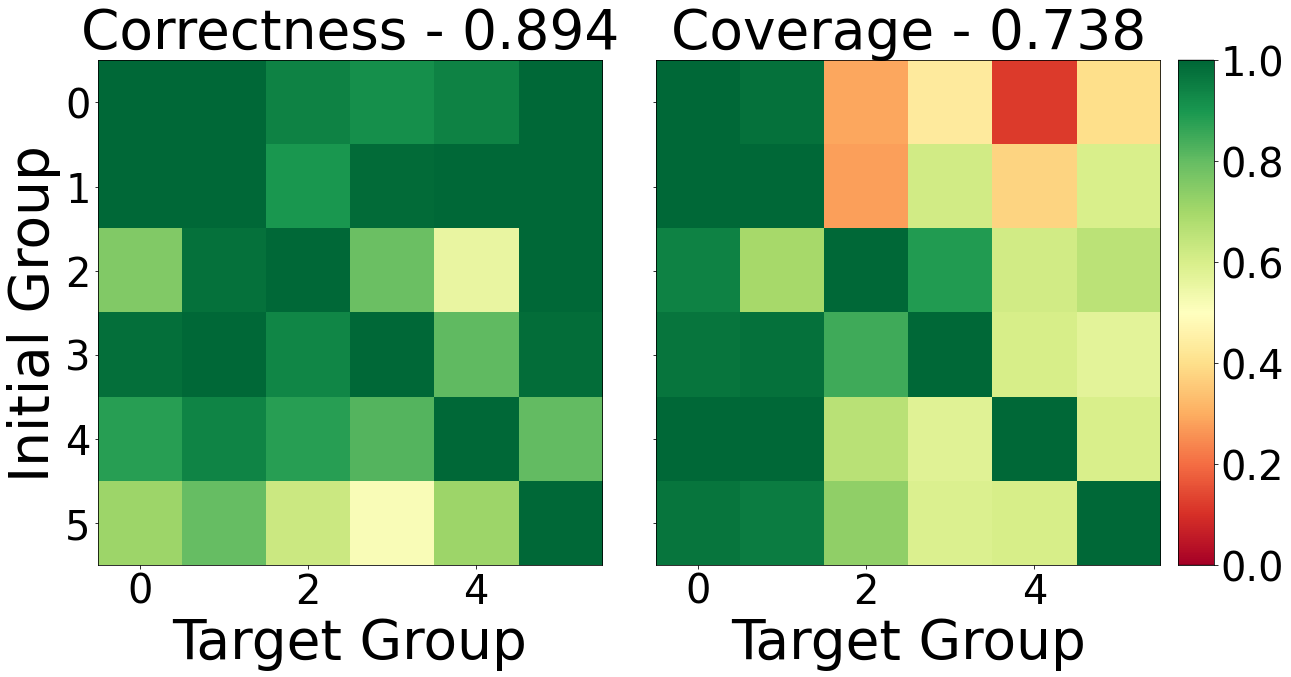

INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


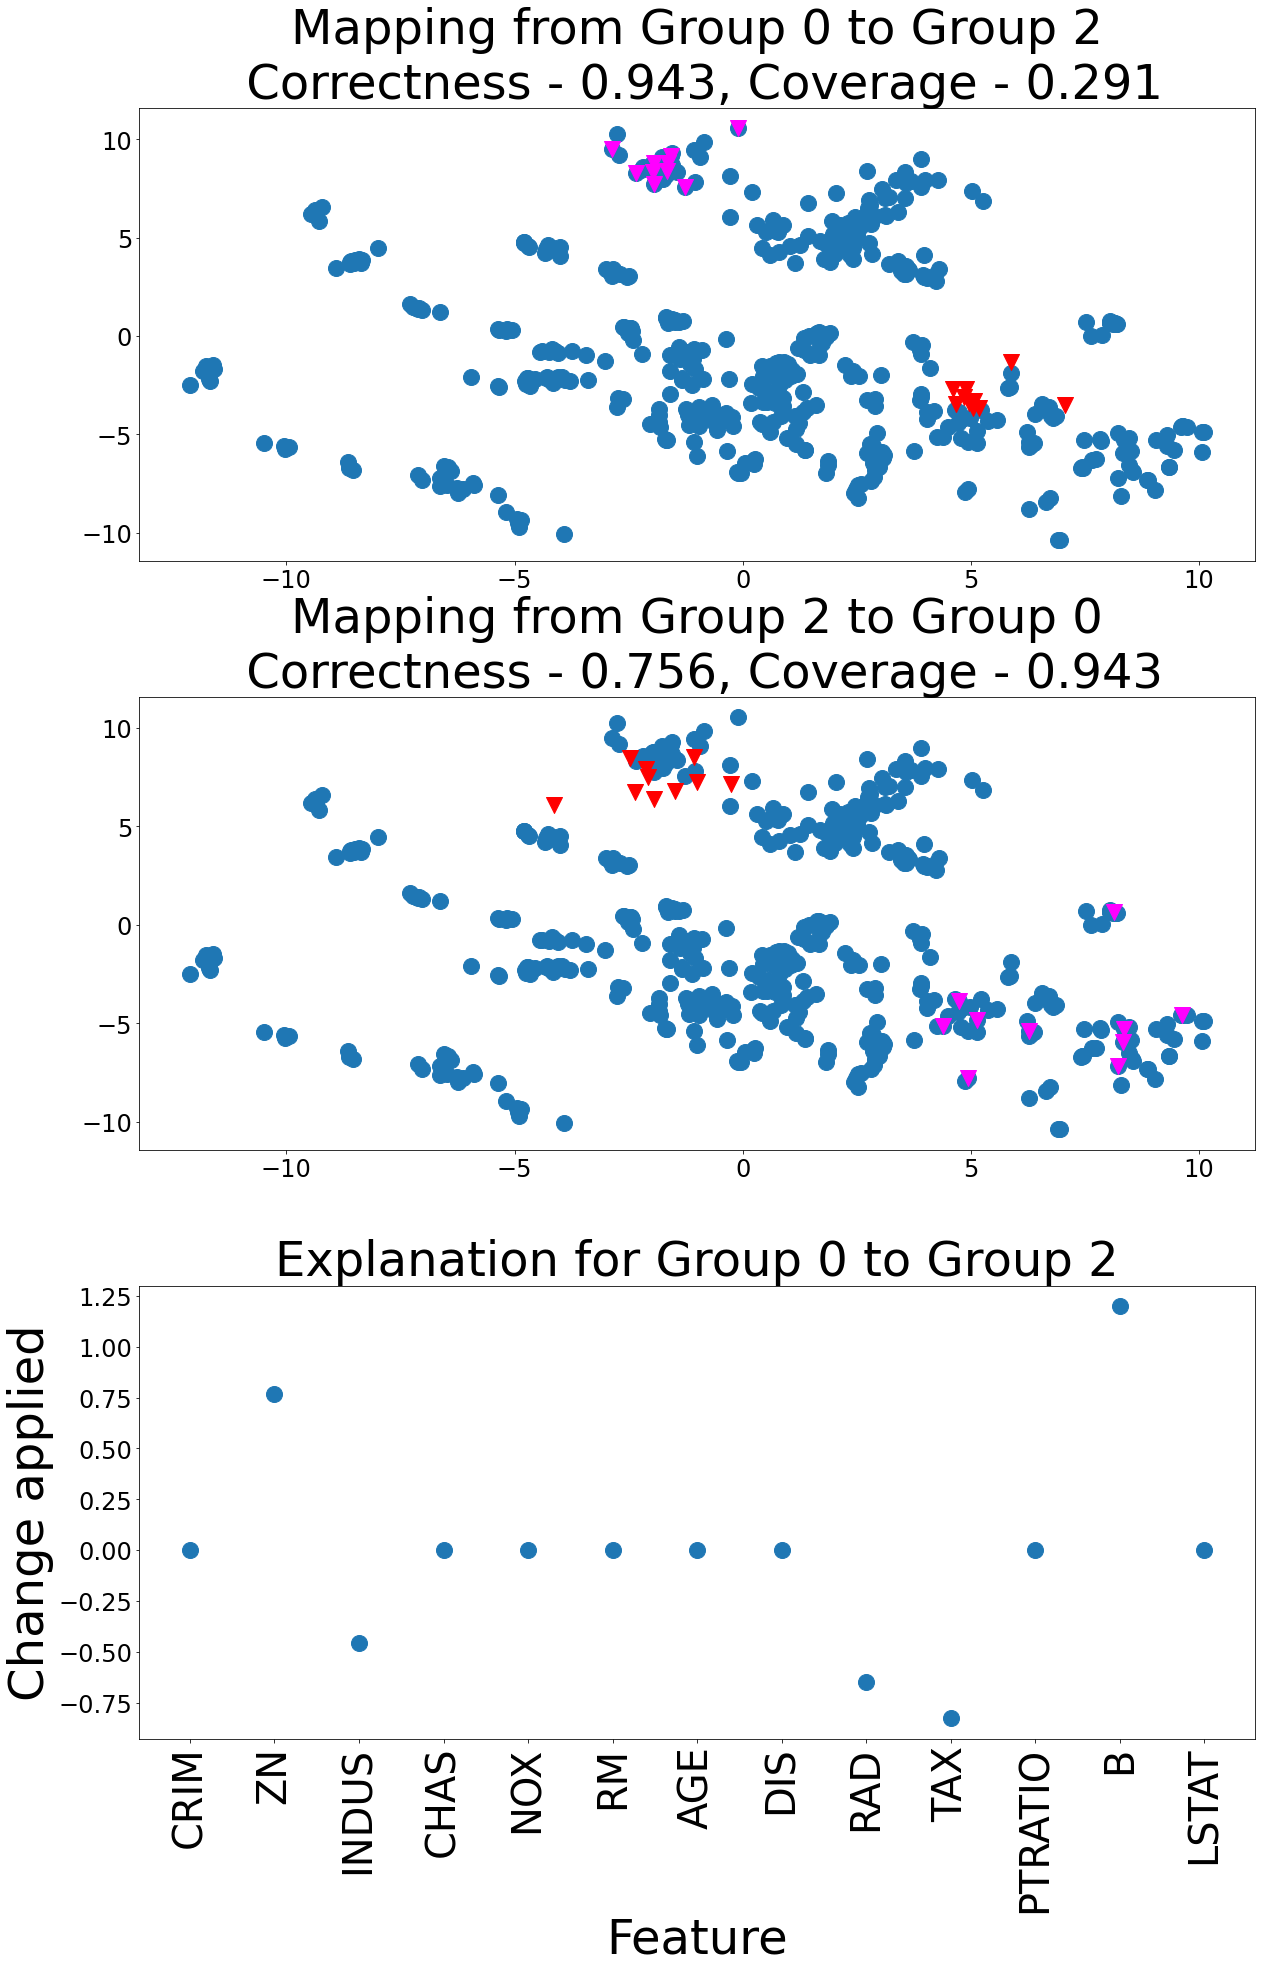

INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


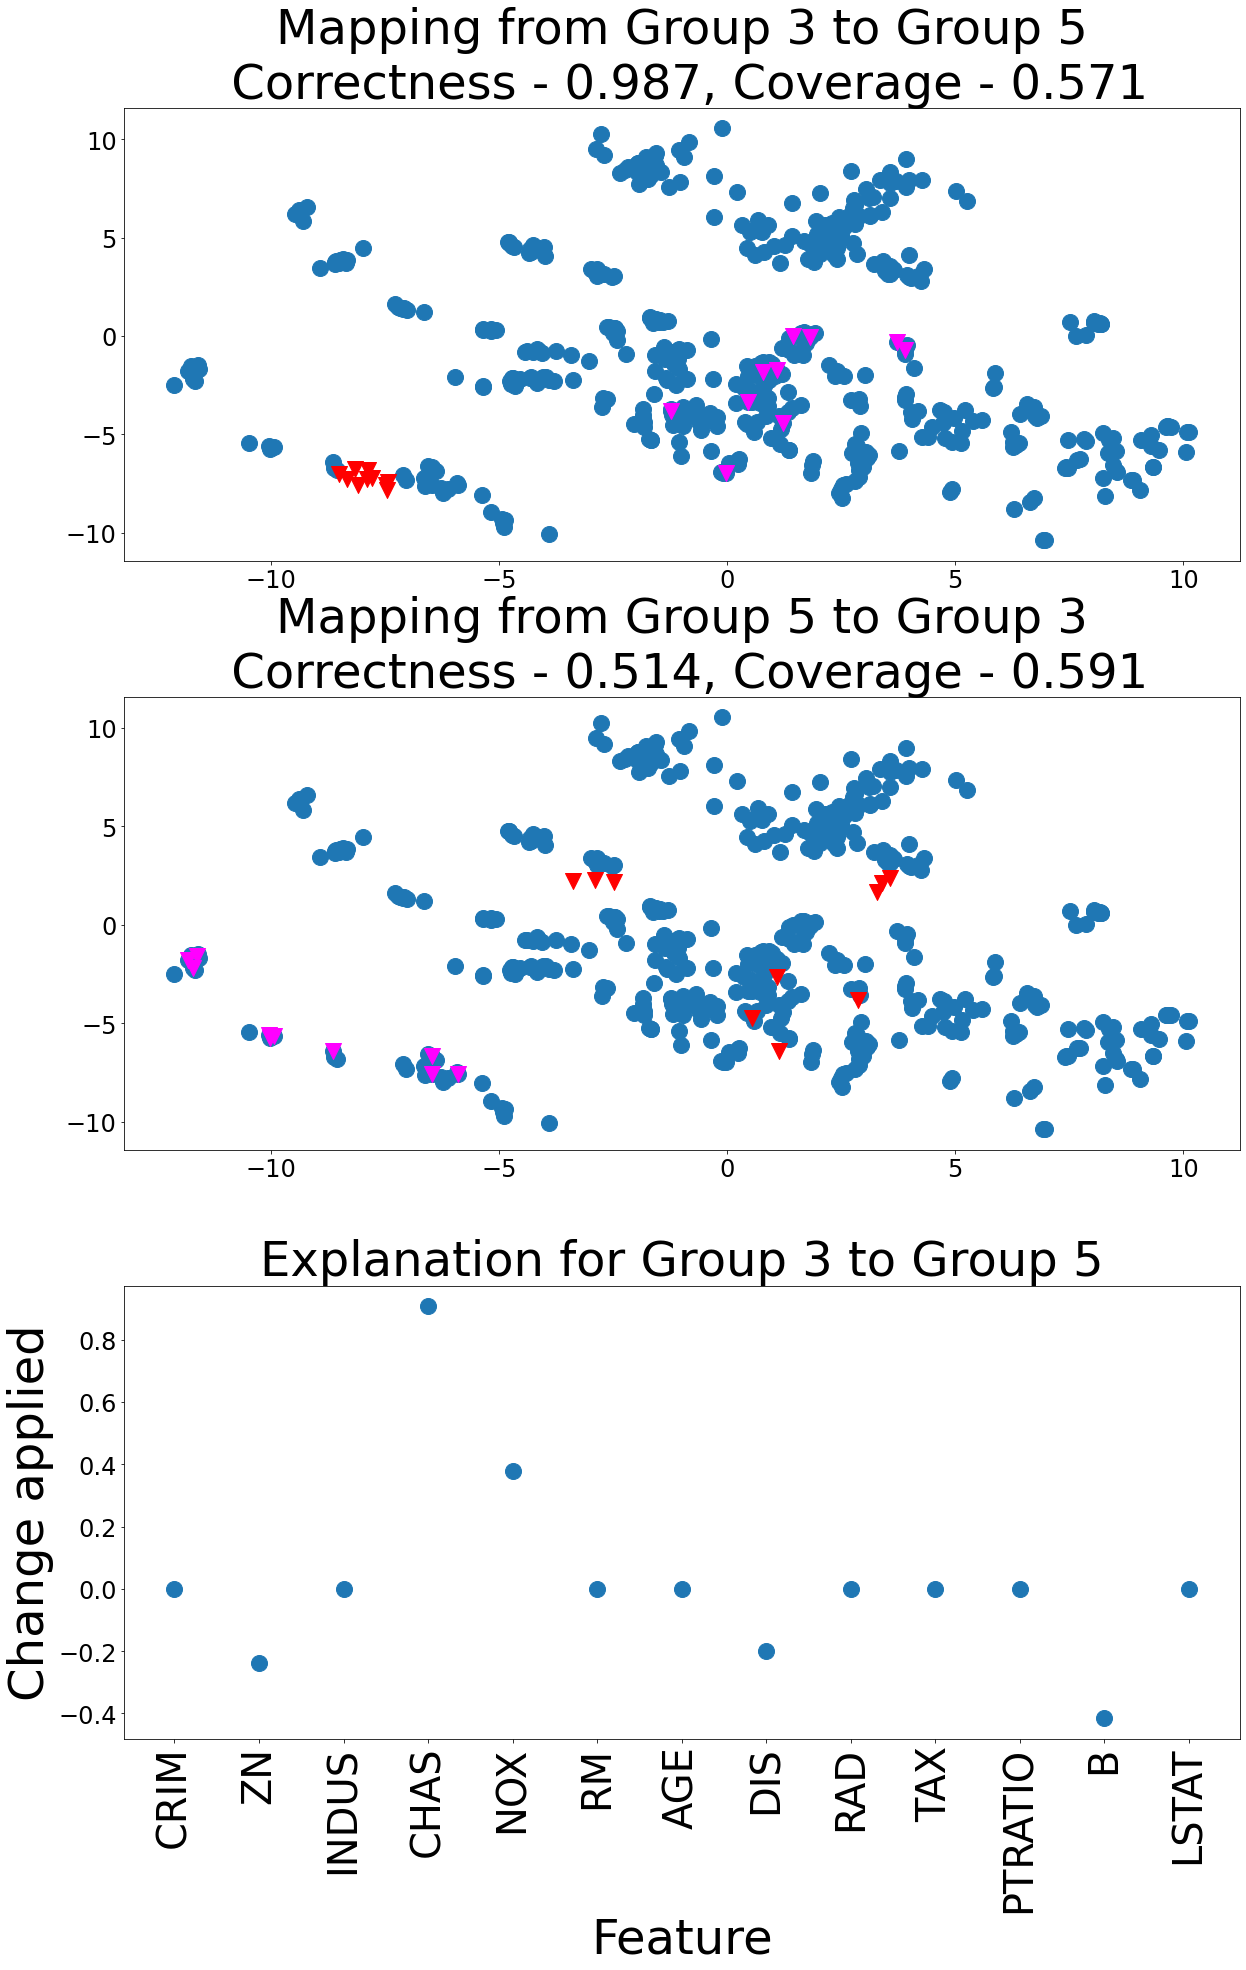

INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


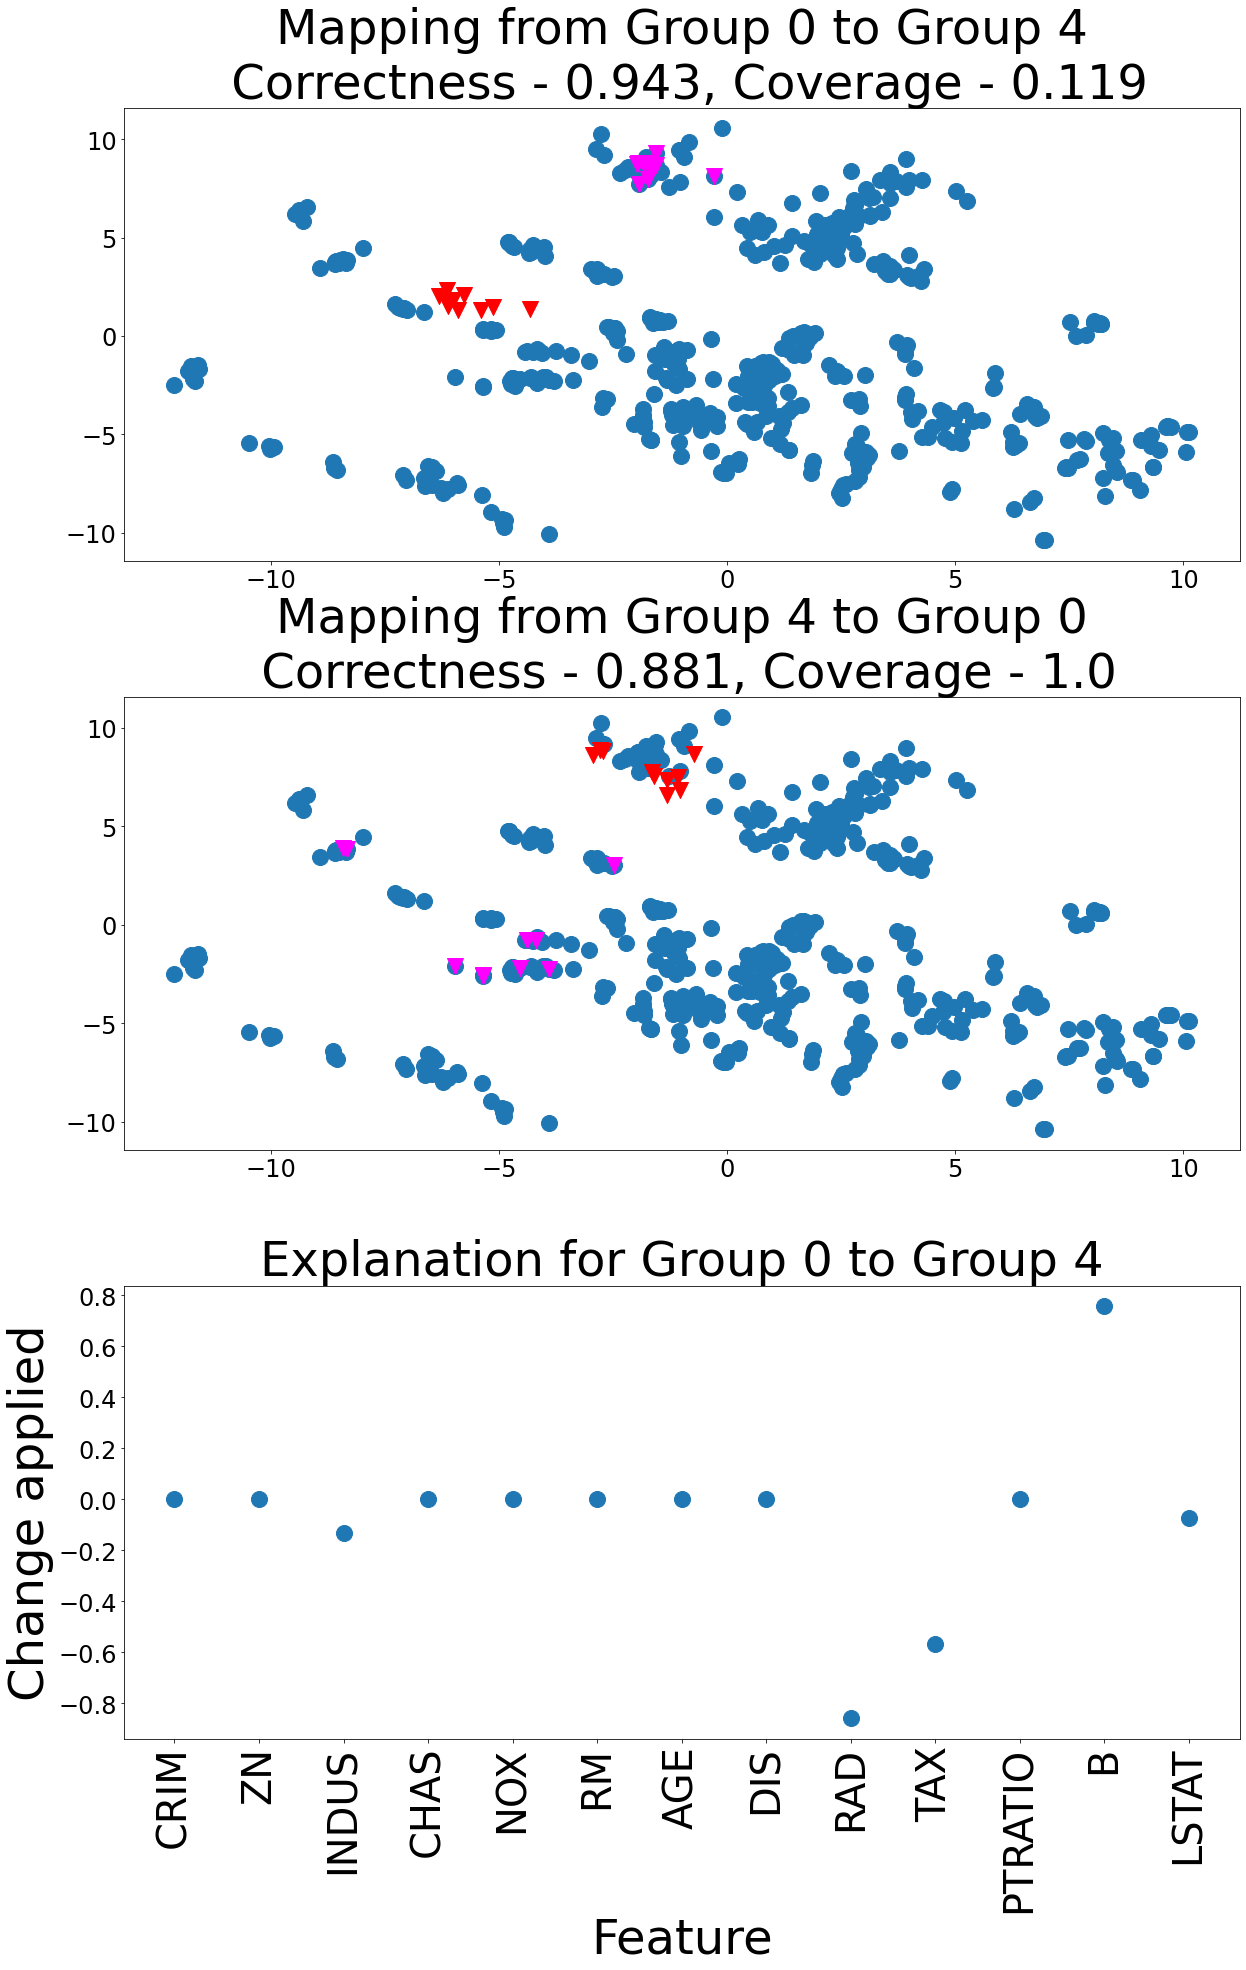

In [8]:
# Evaluate the explanations

deltas = np.load("../../ELDR-reproduction/Housing-K/deltas" + str(k) + ".npy")

a, b = metrics(load_model, x, indices, deltas, epsilon, k = k)

plot_metrics(a, b, name = "housing-metrics.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 2, k = k, num_points = 10, name = "housing-0to2.png", feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 3, 5, k = k,  num_points = 10, name = "housing-3to5.png", feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 4, k = k,  num_points = 10, name = "housing-0to4.png", feature_names = feature_names)


In [10]:
deltas.shape

(5, 13)

In [11]:
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
K = [1, 2, 3, 4]
# out = np.zeros((len(K), 4))

# best_deltas = np.zeros((num_clusters - 1, input_dim))

# Evaluate TGTs
# for c,k in enumerate(K):
#   best_val = 0.0
#   for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
#       for trial in range(3):

#           deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
#           a, b = metrics(load_model, x, indices, deltas, epsilon, k = k) 

#           val = np.mean(a)

#           if val > best_val:
#               best_deltas = deltas
#               best_val = val
#               out[c, 0] = best_val
#               out[c, 1] = np.mean(b)


# Evaluate DBMs
exp_mean = np.zeros((num_clusters - 1, input_dim))
for i in range(num_clusters - 1):
    exp_mean[i, :] = means[i + 1] - means[0]

# for c,k in enumerate(K):
#     a, b = metrics(load_model, x, indices, exp_mean, epsilon, k = k)
#     out[c, 2] = np.mean(a)
#     out[c, 3] = np.mean(b)

# print(out)

In [13]:
def eval_classification(X, labels, deltas, dbms, k):

  from sklearn.linear_model import LogisticRegression
  from sklearn.metrics import accuracy_score

  num_clusters = len(np.unique(labels))
  tgt_features = [np.argpartition(deltas[i],-k)[-k:].tolist() for i in range(num_clusters - 1)]
  dbm_features = [np.argpartition(dbms[i],-k)[-k:].tolist() for i in range(num_clusters -1)]

  ##### TGT ######

  # train classifiers
  clfs = []
  for c, idxs in enumerate(tgt_features):
    kx = X[:,idxs]
    ky = (labels == c).astype(int)
    clf = LogisticRegression().fit(kx, ky)
    clfs.append(clf)

  # predict using one-vs-rest ensemble
  preds = []
  for i in range(x.shape[0]):
    probs = []
    for c in range(num_clusters-1):
      pred = clfs[c].predict_proba(x[i, tgt_features[c]].reshape(1, -1))
      probs.append(pred[:,1][0])
    preds.append(np.argmax(probs))

  tgt_acc = accuracy_score(labels, preds)
  
  ##### DBM ######
  clfs = []
  for c, idxs in enumerate(dbm_features):
    kx = X[:,idxs]
    ky = (labels == c).astype(int)
    clf = LogisticRegression().fit(kx, ky)
    clfs.append(clf)

  # predict using one-vs-rest ensemble
  preds = []
  for i in range(x.shape[0]):
    probs = []
    for c in range(num_clusters-1):
      pred = clfs[c].predict_proba(x[i, dbm_features[c]].reshape(1, -1))
      probs.append(pred[:,1][0])
    preds.append(np.argmax(probs))
  
  dbm_acc = accuracy_score(labels, preds)

  return [tgt_acc, dbm_acc]

In [14]:
tgt_res = []
dbm_res = []
num_features = range(1,14)
for k in num_features:
  res = eval_classification(x, labels, deltas, exp_mean, k)
  tgt_res.append(res[0])
  dbm_res.append(res[1])

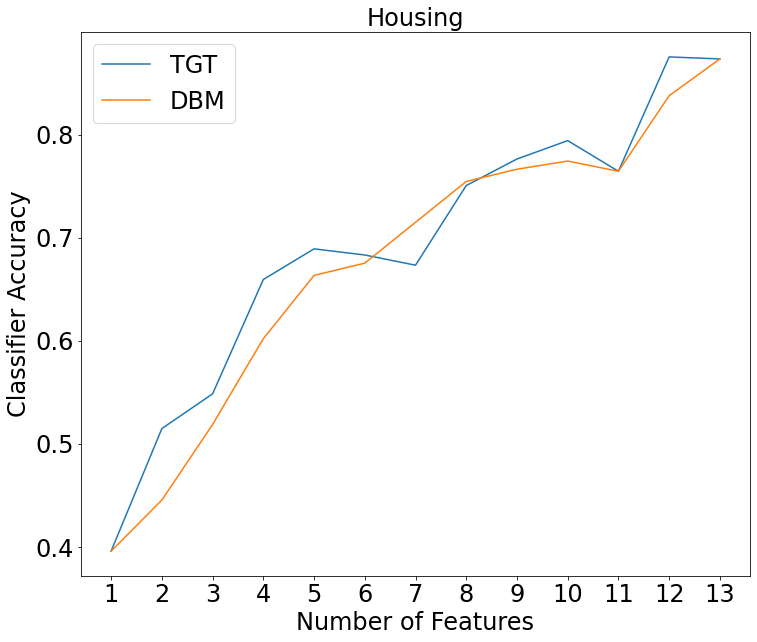

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.plot(num_features, tgt_res, label='TGT')
plt.plot(num_features, dbm_res, label='DBM')
plt.xticks(num_features)
plt.title('Housing',  fontsize=24)
plt.xlabel('Number of Features', fontsize=24)
plt.ylabel('Classifier Accuracy', fontsize=24)
plt.legend(prop={'size': 24})
plt.show()